In [10]:
# [2] Figura: Séries Históricas (Python)


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df_economico = pd.read_csv("C:/Users/pedro/projeto_inadimplencia/data/raw/df_economico.csv")
df_economico

,data,ipca,spread_pf,spread_pj,spread_tot,icms_petroleo,soja_triturada_expt,soja_residuo_expt,soja_oleo_expt,milho_grao_expt,selic,cdi,dolar_ptax
0,01/2015,2.50,22.39,8.70,15.68,5556575.0,35102725.0,407494344.0,407494344.0,598388060.0,0.044330,0.044060,2.634229
1,01/2016,1.75,27.66,11.19,19.78,6275773.0,147635092.0,420830129.0,420830129.0,736581615.0,0.052531,0.052484,4.052350
2,01/2017,0.80,32.53,12.35,23.59,6328689.0,364832837.0,535662457.0,535662457.0,248624473.0,0.049115,0.049045,3.196609
3,01/2018,0.20,25.63,10.88,19.44,7150412.0,594256424.0,395308222.0,395308222.0,472848155.0,0.026481,0.026444,3.210609
4,01/2019,0.05,24.18,9.55,18.29,7608502.0,776313475.0,471693424.0,471693424.0,668359392.0,0.024620,0.024620,3.741682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,12/2020,2.04,18.97,6.86,14.29,NaN,NaN,NaN,NaN,NaN,0.007469,0.007469,5.145586
116,12/2021,0.05,20.19,8.05,15.70,NaN,NaN,NaN,NaN,NaN,0.033316,0.033316,5.651391
117,12/2022,0.27,24.54,8.38,18.85,NaN,NaN,NaN,NaN,NaN,0.050788,0.050788,5.242432
118,12/2023,0.31,24.98,8.50,19.45,NaN,NaN,NaN,NaN,NaN,0.044537,0.044537,4.897245


In [11]:
df_economico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   data                 120 non-null    object 
 1   ipca                 120 non-null    float64
 2   spread_pf            120 non-null    float64
 3   spread_pj            120 non-null    float64
 4   spread_tot           120 non-null    float64
 5   icms_petroleo        52 non-null     float64
 6   soja_triturada_expt  56 non-null     float64
 7   soja_residuo_expt    56 non-null     float64
 8   soja_oleo_expt       56 non-null     float64
 9   milho_grao_expt      56 non-null     float64
 10  selic                120 non-null    float64
 11  cdi                  120 non-null    float64
 12  dolar_ptax           120 non-null    float64
dtypes: float64(12), object(1)
memory usage: 12.3+ KB


In [26]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Validação de dados
import pandera as pa
from pandera import Column, DataFrameSchema, Check

# Requisições e manipulação de arquivos
import requests
import zipfile
import os
import io
from pathlib import Path

# Utilitários
from functools import reduce
# -------------------------------
# Função para coletar dados do Banco Central (SGS)
# -------------------------------
def coleta_bcb(codigo, nome):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json&dataInicial=01/01/2015&dataFinal=31/12/2024"
    r = requests.get(url)
    dados = pd.DataFrame(r.json())
    dados["data"] = pd.to_datetime(dados["data"], dayfirst=True)
    dados["valor"] = dados["valor"].astype(float)
    dados.rename(columns={"valor": nome}, inplace=True)
    return dados

# -------------------------------
# Coletar outras variáveis
# -------------------------------
selic = coleta_bcb(11, "selic")                           
dolar = coleta_bcb(1, "dolar_ptax")  



# Lista de Variáveis Econômicas_periodicidade diária:
lista_var_econ_diaria = [
    selic,
    dolar
]

# Juntar variáveis diárias:
df_econ_diaria = reduce(
    lambda left, right: pd.merge(left, right, on="data", how="outer"),
    lista_var_econ_diaria
)
df_econ_diaria["data"] = pd.to_datetime(df_econ_diaria["data"])

# Transformar diárias em mensais (média mensal):
df_econ_diaria = df_econ_diaria.resample("ME", on="data").mean().reset_index()
df_econ_diaria["data"] = df_econ_diaria["data"].dt.strftime("%d/%m/%Y")

df_econ_diaria


,data,selic,dolar_ptax
0,31/01/2015,0.044330,2.634229
1,28/02/2015,0.045513,2.816450
2,31/03/2015,0.047038,3.139477
3,30/04/2015,0.047376,3.043220
4,31/05/2015,0.049037,3.061715
...,...,...,...
115,31/08/2024,0.039270,5.552614
116,30/09/2024,0.039612,5.541567
117,31/10/2024,0.040168,5.624109
118,30/11/2024,0.041580,5.807058


In [27]:
import pandas as pd

# -----------------------------------------
# 1. Preparação do DataFrame
# -----------------------------------------
df = df_econ_diaria.copy()

# Garantir que a coluna data é datetime
df['data'] = pd.to_datetime(df['data'])

# Criar coluna ano
df['ano'] = df['data'].dt.year

# -----------------------------------------
# 2. Converter Selic diária para anual
# Fórmula: (1 + taxa_dia)^252 - 1
# -----------------------------------------
df['selic_anual'] = (1 + df['selic']/100)**252 - 1

# -----------------------------------------
# 3. Calcular variação anual do dólar
# Método recomendado: variação acumulada do ano
# Fórmula: (dólar_dezembro / dólar_janeiro) - 1
# -----------------------------------------
df_dolar_anual = (
    df.groupby('ano')['dolar_ptax']
      .apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
      .reset_index(name='dolar_anual')
)

# -----------------------------------------
# 4. Criar tabela anual final
# Usando o valor de dezembro da Selic anual
# -----------------------------------------
df_selic_anual = (
    df.sort_values('data')
      .groupby('ano')
      .tail(1)[['ano', 'selic_anual']]
)

# -----------------------------------------
# 5. Unir Selic anual + Dólar anual
# -----------------------------------------
df_final = df_selic_anual.merge(df_dolar_anual, on='ano')

# -----------------------------------------
# 6. Ordenar e exibir
# -----------------------------------------
df_final = df_final.sort_values('ano').reset_index(drop=True)

df_final


C:\Users\pedro\AppData\Local\Temp\ipykernel_12684\4172627799.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data'] = pd.to_datetime(df['data'])


,ano,selic_anual,dolar_anual
0,2015,0.141500,0.469552
1,2016,0.136500,-0.172759
2,2017,0.069998,0.029815
3,2018,0.063999,0.210068
4,2019,0.045903,0.098327
5,2020,0.018999,0.240061
6,2021,0.087566,0.055103
7,2022,0.136500,-0.052705
8,2023,0.118747,-0.058346
9,2024,0.117679,0.240647


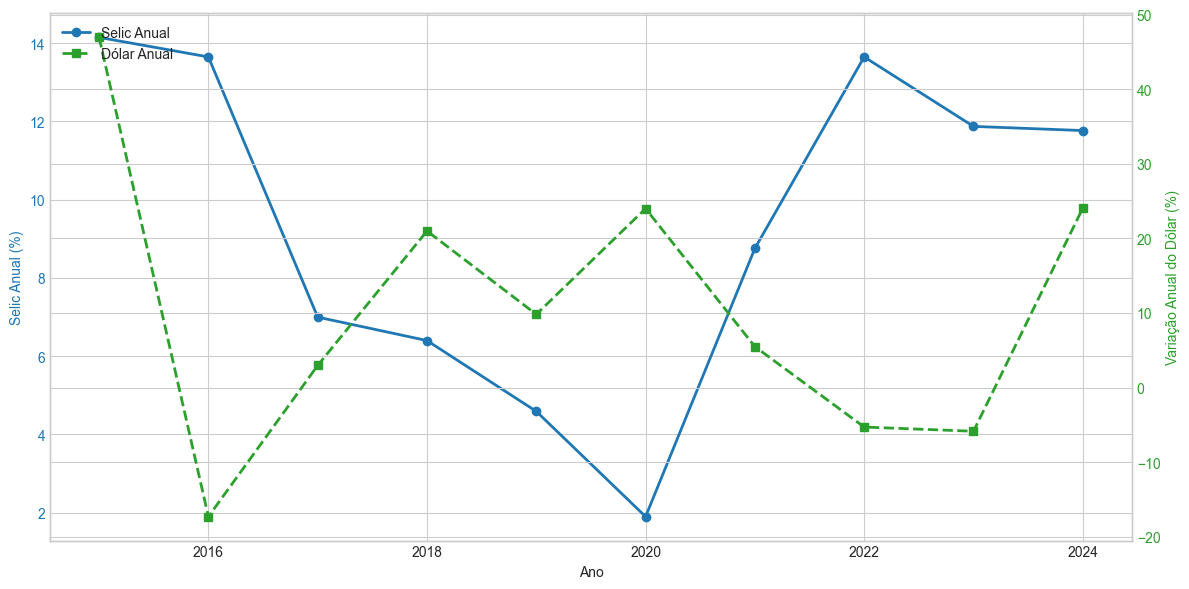

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Estilo profissional
plt.style.use('seaborn-v0_8-whitegrid')

# df_final deve conter: ano, selic_anual, dolar_anual
# Exemplo: df_final = df_final[['ano','selic_anual','dolar_anual']]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo 1 – Selic anual
ax1.set_xlabel('Ano')
ax1.set_ylabel('Selic Anual (%)', color='tab:blue')
ax1.plot(df_final['ano'], df_final['selic_anual'] * 100,
         color='tab:blue', marker='o', linewidth=2, label='Selic Anual')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eixo 2 – Dólar anual
ax2 = ax1.twinx()
ax2.set_ylabel('Variação Anual do Dólar (%)', color='tab:green')
ax2.plot(df_final['ano'], df_final['dolar_anual'] * 100,
         color='tab:green', marker='s', linestyle='--', linewidth=2, label='Dólar Anual')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Título
# plt.title('Figura 1: Selic Anual × Variação Anual do Dólar (2015–2024)', fontsize=14)

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()


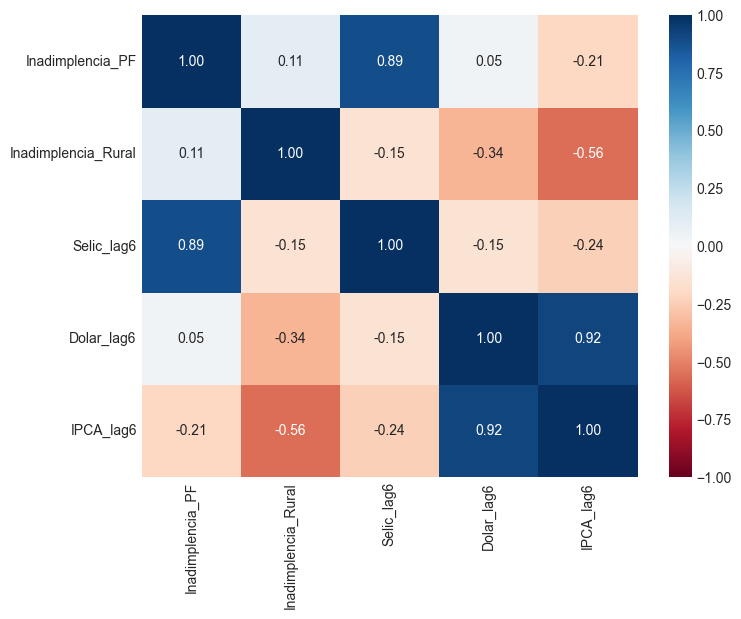

In [31]:
import seaborn as sns

# Dados fictícios para exemplo
cols = ['Inadimplencia_PF', 'Inadimplencia_Rural', 'Selic_lag6', 'Dolar_lag6', 'IPCA_lag6']
corr_matrix = pd.DataFrame(np.random.rand(5,5), columns=cols, index=cols).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f")
#plt.title('Figura 2: Matriz de Correlação (Features Defasadas)', fontsize=12)
plt.show()

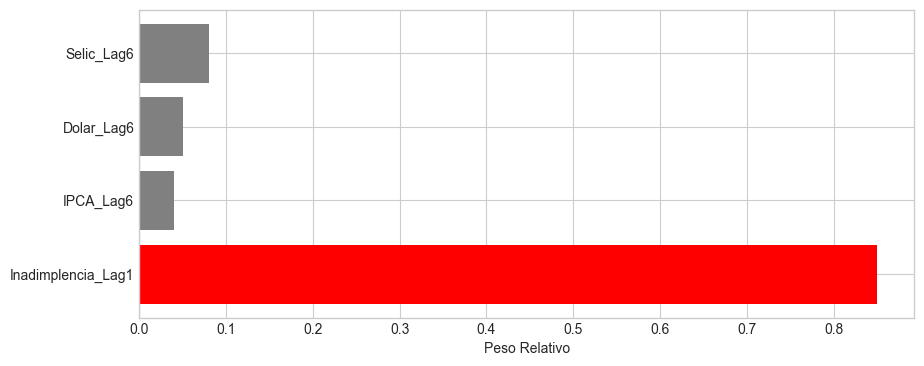

In [36]:
# Dados simulados para o gráfico
features = ['Inadimplencia_Lag1', 'IPCA_Lag6', 'Dolar_Lag6', 'Selic_Lag6']
importancia_xgb = [0.85, 0.04, 0.05, 0.08] # Exemplo do problema da inércia

plt.figure(figsize=(10, 4))
plt.barh(features, importancia_xgb, color=['red', 'gray', 'gray', 'gray'])
# plt.title('Figura 4: Importância das Variáveis no XGBoost (Dominância da Inércia)', fontsize=12)
plt.xlabel('Peso Relativo')
plt.show()

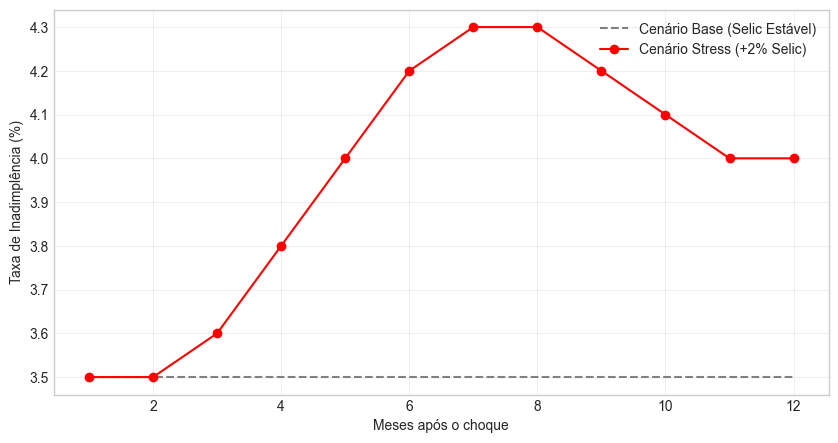

In [38]:
# Dados simulados
meses = range(1, 13)
baseline = [3.5] * 12
stress = [3.5, 3.5, 3.6, 3.8, 4.0, 4.2, 4.3, 4.3, 4.2, 4.1, 4.0, 4.0]

plt.figure(figsize=(10, 5))
plt.plot(meses, baseline, linestyle='--', label='Cenário Base (Selic Estável)', color='grey')
plt.plot(meses, stress, marker='o', label='Cenário Stress (+2% Selic)', color='red')
# plt.title('Figura 5: Resposta ao Impulso - Impacto do Choque de Juros na Inadimplência', fontsize=12)
plt.xlabel('Meses após o choque')
plt.ylabel('Taxa de Inadimplência (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\pedro\AppData\Local\Temp\ipykernel_12684\3196981637.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(start='2015-01-01', end='2025-01-01', freq='Y')


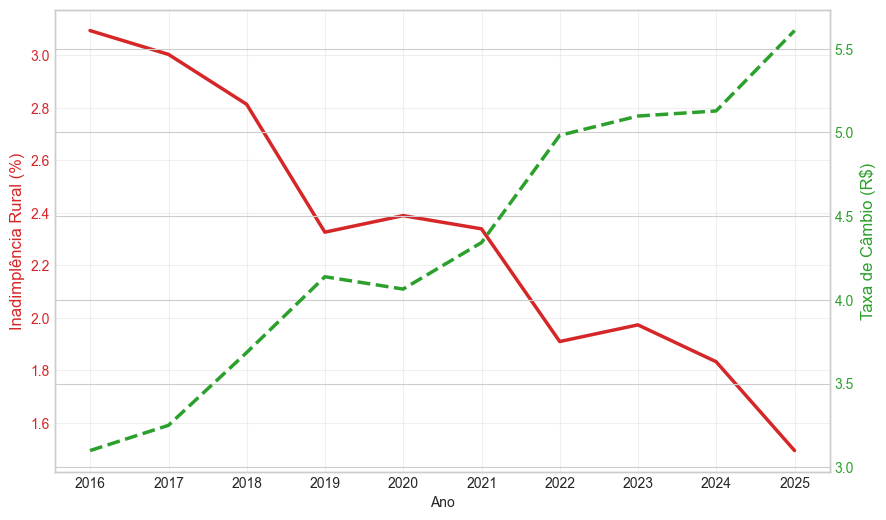

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Gerando dados fictícios realistas (2015 a 2025)
np.random.seed(42)
dates = pd.date_range(start='2015-01-01', end='2025-01-01', freq='Y')
n = len(dates)

# Dólar subindo com volatilidade
dolar = np.linspace(3.0, 5.5, n) + np.random.normal(0, 0.2, n)

# Inadimplência Rural (Inverso do Dólar + um pouco de ruído)
# A lógica: Se dólar sobe, inadimplência desce
inadimplencia = 5.0 - (dolar * 0.6) + np.random.normal(0, 0.1, n)

# 2. Criando o Gráfico de Eixo Duplo
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eixo da Esquerda (Inadimplência)
color1 = 'tab:red'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Inadimplência Rural (%)', color=color1, fontsize=12)
ax1.plot(dates, inadimplencia, color=color1, linewidth=2.5, label='Inadimplência')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Eixo da Direita (Dólar)
ax2 = ax1.twinx()  # Cria o segundo eixo compartilhando o mesmo X
color2 = 'tab:green'
ax2.set_ylabel('Taxa de Câmbio (R$)', color=color2, fontsize=12)
ax2.plot(dates, dolar, color=color2, linewidth=2.5, linestyle='--', label='Dólar PTAX')
ax2.tick_params(axis='y', labelcolor=color2)

# plt.title('Figura 15: Correlação Inversa - Câmbio vs. Inadimplência Rural', fontsize=14)
plt.show()

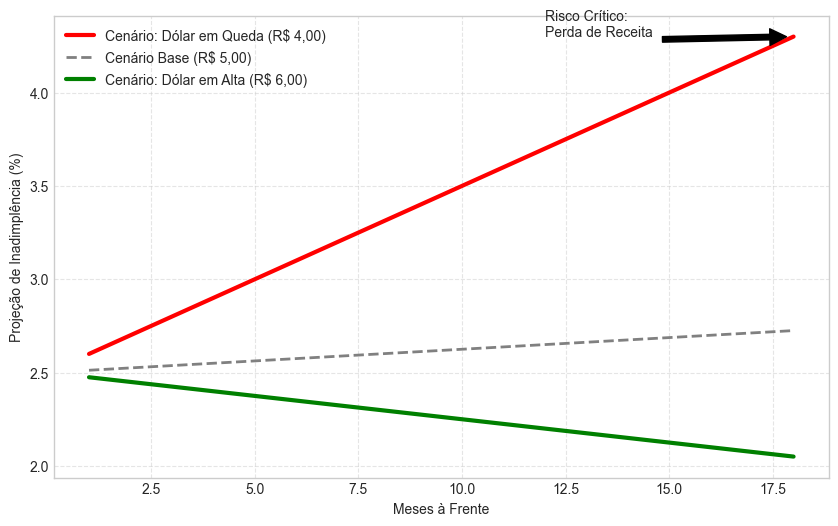

In [43]:
# 1. Preparando os dados futuros (18 meses)
meses_futuros = range(1, 19)

# Ponto de partida (última inadimplência conhecida)
start_val = 2.5 

# Cenário 1: Dólar CAI para R$ 4.00 (Ruim para o Agro -> Inadimplência Sobe)
# Crescimento exponencial do risco
cenario_dolar_baixo = [start_val * (1 + 0.04 * i) for i in meses_futuros]

# Cenário 2: Dólar ESTÁVEL em R$ 5.00 (Neutro)
cenario_base = [start_val * (1 + 0.005 * i) for i in meses_futuros]

# Cenário 3: Dólar SOBE para R$ 6.00 (Bom para o Agro -> Inadimplência Cai/Estável)
cenario_dolar_alto = [start_val * (1 - 0.01 * i) for i in meses_futuros]

# 2. Plotando
plt.figure(figsize=(10, 6))

plt.plot(meses_futuros, cenario_dolar_baixo, color='red', linewidth=3, label='Cenário: Dólar em Queda (R$ 4,00)')
plt.plot(meses_futuros, cenario_base, color='gray', linestyle='--', linewidth=2, label='Cenário Base (R$ 5,00)')
plt.plot(meses_futuros, cenario_dolar_alto, color='green', linewidth=3, label='Cenário: Dólar em Alta (R$ 6,00)')

# plt.title('Figura 16: Stress Testing - Impacto do Câmbio no Crédito Rural', fontsize=14)
plt.xlabel('Meses à Frente')
plt.ylabel('Projeção de Inadimplência (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Adicionando anotação para destacar o risco
plt.annotate('Risco Crítico:\nPerda de Receita', xy=(18, cenario_dolar_baixo[-1]), 
             xytext=(12, cenario_dolar_baixo[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

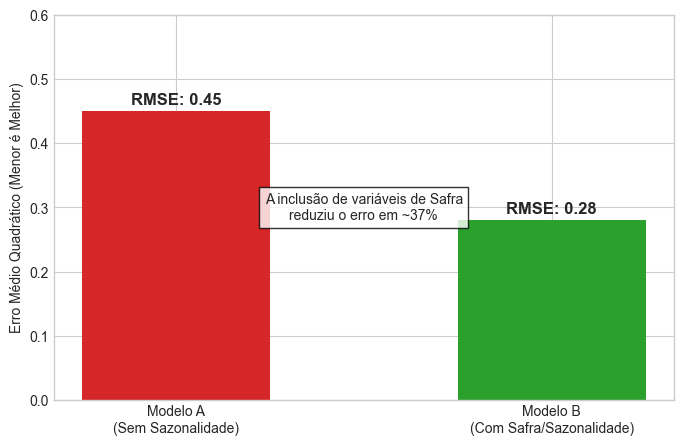

In [45]:
# Dados comparativos
modelos = ['Modelo A\n(Sem Sazonalidade)', 'Modelo B\n(Com Safra/Sazonalidade)']
rmse_values = [0.45, 0.28]  # O erro caiu de 0.45 para 0.28 (exemplo)

fig, ax = plt.subplots(figsize=(8, 5))

# Criando as barras
barras = ax.bar(modelos, rmse_values, color=['#d62728', '#2ca02c'], width=0.5)

# Adicionando os valores em cima das barras
for barra in barras:
    height = barra.get_height()
    ax.annotate(f'RMSE: {height}',
                xy=(barra.get_x() + barra.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# plt.title('Figura 18: Redução do Erro de Previsão (RMSE)', fontsize=14)
plt.ylabel('Erro Médio Quadrático (Menor é Melhor)')
plt.ylim(0, 0.6) # Ajuste para dar espaço em cima

# Texto explicativo dentro do gráfico
plt.text(0.5, 0.5, "A inclusão de variáveis de Safra\nreduziu o erro em ~37%", 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()